In [11]:
import pandas as pd
import numpy as np
import sklearn as sk

from sklearn.preprocessing import StandardScaler
from sklearn import tree

## Random Forests

In previous lessons we've covered the basics of decision trees and bootstrap aggregating, but in this lesson, we'll turn our spotlight solely on Random Forests.

### *Why Random Forests?*

  A random forest uses the age old saying "two (or more) heads are better" than one and applies it to decsion trees. We saw that a decision tree splits the dataset on various features and that it's essential to place priority on feature splits that best seperate the dataset.

Even though they are widely applicable and easy to visualize, *decision trees have their downsides*:
- At *high depths*, they can create unnecessarily complex trees that *overfit* the data.
- Can be very highly unpredictable when slightly changing up the dataset.
- Since decision trees rely on *heuristics* (basically a user-defined metric to say how well the tree is splitting up the dataset) those heuristics can't be guaranteed to always find the optimum tree.

These above problems that a single decision tree faces can be mitigated by a little help from its friends... more decision trees!

Essentially a random forest divys up the tasks of finding the best features to split on among different decision trees and let's them run their course on these features. After some defined time to stop, the trees congregate together in an *ensemble* to compare their findings and find an average feature split that works best off of what they've found.




# Question 1. Let's Explore This Forest! But, First, A Little Recap

I know, I want to get right to creating Random Forests too, but we need to take a step back and make sure we understand how decision trees work.

Fill in the equations for Gini Impurity and Entropy and run the following cell to see them graphed for the range of proabilites $ 0 \leq p_i \leq 1 $.


In [80]:
import math
## -- TO DO -- ##
def gini_impurity(probability):
  return probability * (1 - probability)
## -- END -- #

In [113]:
## -- TO DO -- ##
def entropy(probability):
  return -1*(probability * math.log2(probability))
## -- END -- ##

Text(0, 0.5, 'Function Values')

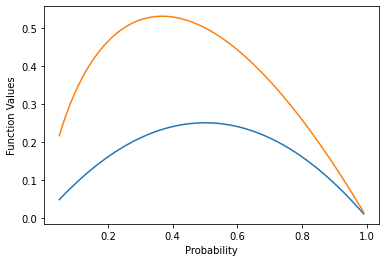

In [114]:
from matplotlib import pyplot as plt

vals = np.arange(.05, 1, .01)
gini_impurity_vals = [gini_impurity(prob) for prob in vals] #To fill in
entropy_vals = [entropy(prob) for prob in vals] #To fill in 
plt.plot(vals, gini_impurity_vals, label="Gini Impurity")
plt.plot(vals, entropy_vals, label="Entropy")
plt.xlabel("Probability")
plt.ylabel("Function Values")

# Entropy is in Orange and Gini Impurity in Blue


#### Question 1.1.1 *What do you observe about the value of the Gini vs. Entropy plots?
```
# Write your answer here:
# (The values of Entropy reach greater values than Gini Impurity.)
```

# Question 2. Refining Our Data
Now let's get working towards predicting these MPGs for Jones from the notes. We'll be working with a dataset originally from the Statlib library at Carnegie Mellon.

### Dataset Properties
1.  1 **mpg** column for the car's fuel efficiency in miles per gallon.
2. 8 columns of other car attributes: 5 continuous and 3 categorical.
3. 398 rows/instances of cars.





## Q 2.1: Importing the Dataset and Initial Impressions
Let's first import this dataset and take a peek at the columns and their values to
 see how we can divide our MPG values into classes to get the ball (or tire) rolling!

In [15]:
#import the auto-mpg csv in using pandas
cars = pd.read_csv("auto-mpg.csv")
cars

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


Highest (Most Efficient) MPG:  46.6
Lowest (Least Efficient) MPG:  9.0


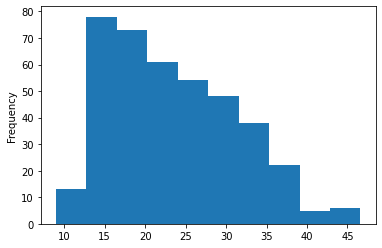

In [16]:
## -- TO DO -- ##
## Plot the mpg values using pandas as a histogram and fill in the max and min mpgs ##
cars.mpg.plot(kind='hist')

mpg_max = max(cars.mpg)
mpg_min = min(cars.mpg)
## -- END -- ##
print("Highest (Most Efficient) MPG: ", mpg_max) ## SHOULD EQUAL 46.6
print("Lowest (Least Efficient) MPG: ", mpg_min) ## SHOULD EQUAL 9.0

### Q2.1.1 What did you find as the largest and smallest miles per gallons?
```
# Write your answer here:
# (46.6, 9.0)
```

As we can see, there's quite a range in MPG that a car could have. They are also skewed to one side.

## Q 2.2: Adjusting Our Data

To make our process easier, lets divide our data up into four named categories, depending on the range of MPGs it falls under and how much we'd want to buy it.
- **0:**  (5.0 < MPG <= 14.9)
- **1:**  (15.0 < MPG <= 24.9)
- **2:**  (25.0 < MPG <= 34.9)
- **3:**  ( 35.0 < MPG <= 50.0)


Let's now create a **desire_creator** function, which outputs an array created from the MPG column of the **cars** dataset, where if the MPG falls into a certain value range as specified above, we insert the corresponding value.

For example, if the mpgs column were an array:
```
mpgs = [34.5, 42.3, 22.9]
desires = desire_creator(mpgs)
print(desires)
[2, 3, 1]
```

In [17]:
# Should return an array containing the desirability ranking deduced from the mpg 
# cars_dataset: 
def desire_creator(cars_dataset):
  desires = []
  ## -- TO DO -- ##
  for mpg in np.asarray(cars_dataset.mpg):
    if (mpg > 5.0 and mpg <= 14.9):
      desires.append(0)
    elif (mpg >= 15.0 and mpg <= 24.9):
      desires.append(1)
    elif (mpg >= 25.0 and mpg <= 34.9):
      desires.append(2)
    elif (mpg >= 35.0 and mpg <= 50.0):
      desires.append(3)
    else:
      raise Exception("Unexpected MPG:", mpg)
    ## -- END -- ##
  return np.asarray(desires)

In [18]:
desirability = desire_creator(cars)

Let's create a new dataset named **cars_and_desires** replacing the **mpg** column with **desirability**.

Also, since sklearn's random tree classifier only works numeric data, we'll have to drop the **car name** and **horspepower** columns, given they are *string* and *object* types respectively.

In [19]:
## -- TO DO: -- ##
cars_and_desires = cars.copy()
cars_and_desires.columns
cars_and_desires = cars_and_desires.drop(['mpg'], axis=1)
cars_and_desires = cars_and_desires.drop(['car name'], axis=1)
cars_and_desires = cars_and_desires.drop(['horsepower'], axis=1)
cars_and_desires['desirability'] = desirability
## -- END -- ##

In [20]:
cars_and_desires

,cylinders,displacement,weight,acceleration,model year,origin,desirability
0,8,307.0,3504,12.0,70,1,1
1,8,350.0,3693,11.5,70,1,1
2,8,318.0,3436,11.0,70,1,1
3,8,304.0,3433,12.0,70,1,1
4,8,302.0,3449,10.5,70,1,1
...,...,...,...,...,...,...,...
393,4,140.0,2790,15.6,82,1,2
394,4,97.0,2130,24.6,82,2,3
395,4,135.0,2295,11.6,82,1,2
396,4,120.0,2625,18.6,82,1,2


Let's see this histogram of the desirabilities to get an idea of what proportion of cars are desirable

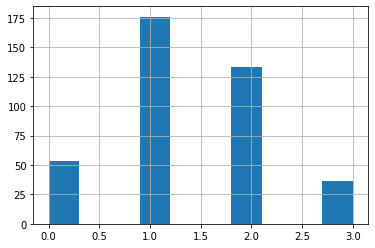

In [21]:
cars_and_desires.desirability.hist()

Now that we have our data/attributes and labels together... it only makes sense to split them apart, right?

Let's make our data `X` and our features `y` given an `index`, where to the left of the index is the test data, to the right, the labels.



In [71]:
# Splits the dataset into an X of the data/attributes, and y of the features on a given index.
# dataset: incoming dataset to be split
# index: the index of final column that is be split off to create the features
def data_label_splitter(dataset, index):
  ## -- TO DO -- ##
  X = dataset.iloc[:, 0:index]
  y = dataset.iloc[:, index] 
  ## -- END -- ##
  return X, y

Let's now fill in this function to divide our `X` and `y` into test trains splits given a `test_fraction`.

##### *Hint:* Look at the imports at the top of the page.
##### *Make sure to set `random_state = 42` otherwise, we may run into problems down the line.*

In [72]:
# Splits the dataset into testing and training data:
# X: The data matrix
# y: The labels column
# test_fraction: What fraction (float) of the data will go to the test set
def train_test_splitter(X, y, test_fraction):
  ##-- TO DO --##
  return train_test_split(X, y, test_size=test_fraction, random_state = 42)
  ## -- END -- ##


I know filling out these functions is annoying -- they'll come in handy later, I swear. Fill in the method parameters below. Let's first have our testing data to be $\frac{2}{10}$ of the overall dataset.

In [73]:
from sklearn.model_selection import train_test_split

test_fraction = 0.2 ## Assign fraction value
X, y = data_label_splitter(cars_and_desires, 6) ## Fill in method parameter
X_train, X_test, y_train, y_test = train_test_splitter(X, y, test_fraction) ## Fill in method parameters

We've now got our car data all prepared for Jones.



# Question 3: Classification
Now that we finally have our test and training data set up, all we have to do is create a Decision Tree Classifier, fit our X and y training data to the classifier, and see how the prediction on training data performs.

We'll use Scikit-Learn (`sklearn`) to first create a Decision Tree Classifier and run some tests to see how accurately Jones' could perform doing the searching himself, without an ensemble of henchmen to aggregate their findings.

Then, we'll then use Scikit-Learn's Random Forest Classifier to simulate if Jones did employ his henchmen. After we do this, we'll compare the results of the Decision Tree and Random Forest to report back to Jones if employing his henchman is a good idea or not.

##### *Make sure to set `random_state = 42` otherwise, we may run into problems down the line.*

## Q 3.1: Decision Tree Classifier

In [74]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import  accuracy_score

tree_classifier = tree.DecisionTreeClassifier(random_state=42) ## To Fill In
tree_classifier.fit(X_train, y_train) # To Fill in 
tree_y_pred = tree_classifier.predict(X_test) #To Fill in 

accuracy = accuracy_score(y_test,tree_y_pred) # To Fill in
print(accuracy)

assert(.73 <= accuracy and accuracy <= .74)

0.7375


Try running the above cell a few times without a `random_state` set and see if the accuracy changes. *Did you fix `random_state` to a certain value?* Make sure you understand what assigning `random_state` does within Scikit functions.


## Q 3.2 Random Forests Classifier
Let's now create our Random Forest Classifier, with `20` trees (aka 20 of Jones' henchmen).

In [90]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(n_estimators=50, random_state=42, criterion="gini") ## To Fill In
forest_classifier.fit(X_train, y_train) ## To Fill In
forest_y_pred = forest_classifier.predict(X_test) # To fill In

accuracy = accuracy_score(y_test, forest_y_pred)
print(accuracy)

assert(.72 <= accuracy and accuracy <= .79)

0.7875
Index(['cylinders', 'displacement', 'weight', 'acceleration', 'model year',
       'origin'],
      dtype='object')
[0.11529256 0.2314472  0.29116423 0.13254122 0.19204289 0.03751189]


#### Q 3.2.1 *Does the forest perform better than a tree? Is it worth it for Jones to employ `20` henchmen?*


```
# Write you answer here:
# (Yes, the random forest performs better -- 77.5% > 73.8%; Jones should employ his henchmen)
```

*How about `50`, `100`, and `500`?* Run the cell above on each a few times with each count. Note how the variance in accuracies change.

Below fill in the function which returns the accuracy of a single run of the random forest classifier.

`splits` should be a list of three variables, with each index consisting of:
- **index 0:** training data
- **index 1:** training labels
- **index 2:** test data
- **index 3:** test labels

In the second block of code, experiment with differing `number_of_trees` and `num_rand_seeds` values. 
#### Q 3.2.2 *Do you notice any trends related to the number of trees and the metrics of accuracies?*

```
# Write your answer here:
# (The accuracy should increase between 20 and 50, but 100 and 500 should see no change in accuracy, little progress is made)
```


Fill in the function `random_forest_test` below which creates a `RandomForestClassifier` given parameters number of trees (`num_trees`), data and features which have been test-train split into the values of (`splits`), and a random seed (`rand_seed`).

`splits` should be in the format:
- `splits[0]`: Traning data
- `splits[1]`: Traning labels
- `splits[2]`: Test data
- `splits[3]`: Test labels



In [31]:
num_rand_seeds = 10 # Experiment with this value
random_seeds = np.random.randint(100, size=num_rand_seeds)
splits = [X_train, y_train, X_test, y_test] # To Fill In
def random_forest_test(num_trees, splits, rand_seed):
  ## -- TO DO -- ##
  forest_classifier = RandomForestClassifier(n_estimators=num_trees, random_state=rand_seed) 
  forest_classifier.fit(splits[0], splits[1]) 
  forest_y_pred = forest_classifier.predict(splits[2])
  accuracy = accuracy_score(splits[3], forest_y_pred)
  ## -- END -- ##
  return accuracy

## The code below prints the average accuracy from 5 runs of random_forest_test(), with each of the random seeds set above ##
number_of_trees = 4 ## Experiment with this value.
assert(1 <= number_of_trees and number_of_trees <= 500)
accuracies = []
for seed in random_seeds:
  accs = []
  for i in np.arange(5):
    accs.append(random_forest_test(number_of_trees, splits, seed))
  accuracies.append(np.mean(accs))


print(accuracies)
print("Min. Acc. :", min(accuracies))
print("Max. Acc. :", max(accuracies))
print("Avg. Acc. :", np.mean(accuracies))


[0.775, 0.775, 0.7125, 0.7375, 0.7125, 0.7375, 0.7625, 0.7, 0.7125, 0.7125]
Min. Acc. : 0.7
Max. Acc. : 0.775
Avg. Acc. : 0.73375


Increasing the number of trees will come closer to reaching a uniform solution regardless of randomness. Even if Jones selects different henchmen who are bound to go about choosing the desired features in different ways, having a large enough of number of trees/henchmen in the ensemble will reach a standardized solution *given the same training and test data.*

Jones wants to know the ideal number of henchman to employ so he doesn't have any of them wasting their time. Let's plot how the # of trees/henchmen affect the accuracy.

#### Q 3.2.3 *Do you think there will be a dropoff, why or why not?*

```
# Write your answer below:
# (No, the accuracies should not drop off -- once the random forests have reached an almost perfect split given the training data, the random forest will hover around a certain accuracy regardless of how many more trees you add).
# (This question is also to ensure student are not mistaking this test for the bias-variance tradeoff)*
```

In [32]:
tree_counts = np.arange(1, 500, 20)
tree_labels = tree_counts.astype(str)
accs_on_tree_counts = []
for count in tree_counts:
  rand_seeds = np.random.randint(100, size=1)
  accs = []
  for seed in rand_seeds:
    accs.append(random_forest_test(count, splits, seed))
  accs_on_tree_counts.append(np.mean(accs))

Text(0, 0.5, 'Accuracy Percentage')

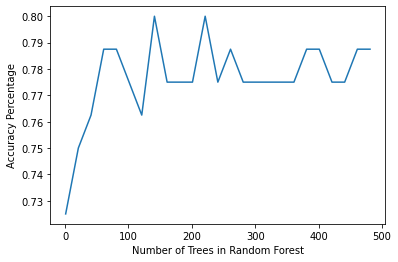

In [33]:
plt.plot(tree_counts, accs_on_tree_counts, label="Accuracy")
plt.xlabel("Number of Trees in Random Forest")
plt.ylabel("Accuracy Percentage")

#### Q 3.2.4 *Around what accuracy does the classifer reach before jumping around randomly?*

```
*(The classifier should reach around 78% to 80% before randomly choosing between a few accuracies)*
```
#### Q 3.2.5 *Intuitively, why does the accuracy rating appear to jump around between a few set values? What is going on here?* **Hint:** *Is this a large dataset? / Think about swing states/counties in elections.*
```
# (The accuracy is jumping around between a few values because the ensembles are congregating a select few splits on datapoints. 
# This is similar to swing states/counties in elections because a significant portion of datapoints / states / counties are guaranteed to be classified a certain way. 
# However there are a few datapoints which have features that will often fall upon the boundaries between classifications. One could think of Miami-Dade or Philadephia county, as examples of datapoints that swing between boundaries)
```

Let's quickly try scaling our features of our data and see if that affects the accuracy of our Random Forests classifier. 

In [99]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
forest_classifier = RandomForestClassifier(n_estimators=50, random_state=42, criterion="gini")
forest_classifier.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
forest_y_pred_scaled = forest_classifier.predict(X_test_scaled)

scaled_accuracy = accuracy_score(y_test, forest_y_pred_scaled)
print(scaled_accuracy)

0.7875


#### Q *3.2.6 Did scaling the data affect the accuracy of the Random Forests Classifier? Why is this so?*
```
# Write your answer here:
# (No, scaling the data did not affect the accuracy of the Random Forest Classifier. Decision Trees work by partitioning rather than say Euclidean distance. Because of this, the scale of the data should not affect the models results.)
```

## Q4 Visualization

Now Jones is curious to know exactly how these decision trees work. He wants us now to visualize a few decision trees to see how the features are being split. For this we'll import `graphviz` and the addon library `dtreeviz`

More info on `dtreeviz` can be found on its github page: https://github.com/parrt/dtreeviz

In [35]:
# Importing graphviz and installing dtreeviz
import graphviz
!pip install dtreeviz

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 204.2MB 55kB/s 
     |████████████████████████████████| 204kB 34.5MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.1.3-cp36-none-any.whl size=52493 sha256=9575ea792b8e5734a5efdae4445f4959e946c8fe36c1d3828b1146436c7b0912
  Stored in directory: /root/.cache/pip/wheels/80/a9/1e/4751fda06e88399ee09410646e9d55c88787276f9537b8ebd0
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=c95dad6bb9b3756e1cf1e487f0d7f9a9d7ff242ee18a5388267369cfb73a8840
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built dtreeviz pyspark


Part of this data analytics job is presenting the information back to the client in a digestible and engaging fashion. 
Assign each of the 4 categories of MPGs an adjective you see fit in `target_names`. For example, `target_names[0] = "horrible"` or `target_names[3] = "ideal"`.

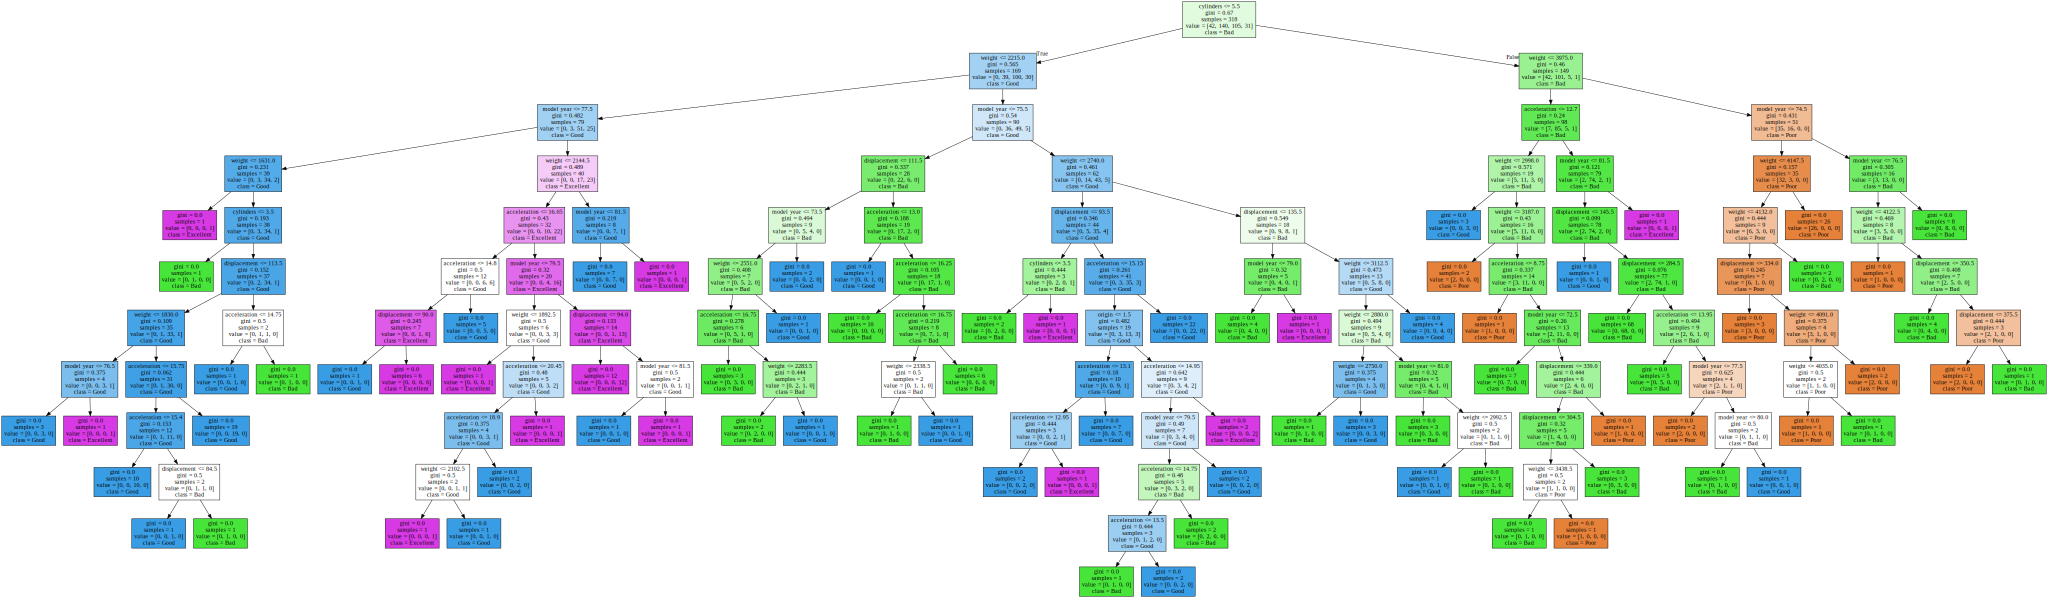

In [36]:
target_names = ["Poor", "Bad", "Good","Excellent"] # Assign four labels for the four groups
dot_data = tree.export_graphviz(tree_classifier, out_file=None, feature_names=X_train.columns, class_names=target_names, filled=True) ## To Fill In
graph = graphviz.Source(dot_data, format="png")
graph


### Q 4.1 Interpreting the Visual Data

Browse around the tree. Do you see clusters of Nodes with various ratings? Look a little upstream and report some desicions/splits that help find the most desirable cars, and some that find the least desirable cars. 

#### Q 4.1.1 *How do you interpret the features and numbers contained in these splits? Do the most substantial splits performed at a low depth practically make sense to you in choosing a car which has a high MPG?*

```
# Write your answers below:
# (As these answers are more personalized, they will vary)
# (A few observations are listed below)
# ("Cylinders >= 5.5 -- Cars with a high number of cylinder burn more fuel)
# ("Weight <= 3975.0 and Weight >= 2215 -- Cars with a high weight require more energy (and therefore gas) to move) 
# ("Model Year <= 77.5 -- Newer cars are built with more fuel efficient design practices)
```

#### Q 4.1.2 *Do you notice any positive or negative outliers among groups of nodes at a high depth in the decision tree?* *What are some splits that precede these outliers?*

**Positive:**
```
# Write your answer(s) below: 
# ("Model Year" being an abnormally late year, for example 79.0, 81.5) (Most noticible)
# ("Acceleration" being slightly higher than similar cars in split) (Harder to notice)
```
**Negative:**
```
# Write your answer(s) below:
# ("Cylinder Count or Acceleration" being abnormally low for similar cars in decision tree")
```

#### Q 4.1.3 *What is value of Gini Impurity when leaf nodes are created? Why is that so? What is occuring when the Gini Impurity is 0.5?*

```
# Write your answers below:
# (The value of the Gini Impurity when the leaf nodes are created in 0.0 -- This is because the dataset is now completely homogenous among the previous split parameters)
# (0.5 -- This means that the datapoints are being split exactly in half)
```
#### Q 4.1.4 Write down the three most crucial splits (in order) you would report back to Jones, to most easily find the best rated cars.
```
# Write your answers below: 
# 1. (Cylinders < 5.5)
# 2. (Weight < 2215.0)
#3. (Model Year > 77.5)
```

Jones also wants to know exactly how important each feature is to Random Forests classification. Luckily sklearn's `RandomForestClassifer` has a helpful parameter `feature_importances_` for this task.

Using `forest_classifer` from Question 3.2 and matplotlib, make a bar plot of each feature and its importance score.

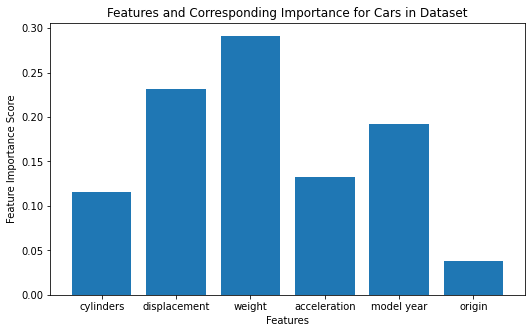

In [112]:
## -- TO DO -- ##
importances = forest_classifier.feature_importances_
features = X_train.columns

plt.bar(features, height=importances, width=.8)
plt.title("Features and Corresponding Importance for Cars in Dataset")
plt.xlabel("Features")
plt.ylabel("Feature Importance Score")
fig = plt.gcf()
fig.set_size_inches(8.5, 5)

## -- END -- ##
# The plot should have sensible labels, title, scale, and information

#### Q 4.1.5 *What are the three most important features?*
```
# Write your answers below:
# (1. Weight)
# (2. Displacement)
# (3. Model Year)
```

That wraps it up! Jones thanks you deeply for your help.